In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hyperopt
from hyperopt import fmin, hp, Trials
import torch.cuda

def get_data(random_state=None):
    # Read the data, specifying the decimal separator
    df = pd.read_excel("final_data492.xlsx", decimal=',')

    # Drop unnecessary columns and separate features and target variable
    df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')
    df = df[df['result_1'] == 2]
    df.dropna(axis=0, inplace=True)

    df_dropped = df.drop(columns=['result_1'])
    df_dropped.drop(columns=['year'], inplace=True)

    X = df_dropped.drop(columns=['result_2'])
    y = df_dropped['result_2'].values

    # Split the data into train and test sets with random_state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [ ]:
# 1 hidden layer NN
class NN1(nn.Module):
    def __init__(self, dropout):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# 2 hidden layer NN
class NN2(nn.Module):
    def __init__(self, dropout):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# 3 hidden layer NN
class NN3(nn.Module):
    def __init__(self, dropout):
        super(NN3, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparameter search spaces
hyperparameter_space = {
    "n_layers": hp.choice("n_layers", [1, 2, 3]),
    "n_epochs": hp.quniform("n_epochs", 5, 50, 1),
    "optimizer": hp.choice("optimizer", ["Adam"]),
    "dropout": hp.uniform("dropout", 0.0, 0.7),
    "learning_rate": hp.loguniform("learning_rate", -12, 0),
    "batch_size": hp.choice("batch_size", [1, 2, 4, 8, 16, 32, 64]),
}


# helper function that returns optimizer
def _get_optimizer(algorithm, learning_rate, model):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #if algorithm == "Adam":
    #    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #elif algorithm == "SGD":
    #    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    #else:
    #    optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
    return optimizer

def _get_model(n_layers, dropout):
    model = None
    if n_layers == 1:
        model = NN1(dropout)
    elif n_layers == 2:
        model = NN2(dropout)
    elif n_layers == 3:
        model = NN3(dropout)
    return model.to(device)  # Move model to CUDA if available

X_train, X_test, y_train, y_test = get_data()

# Convert data into tensors and move to CUDA
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)
# Calculate class weights

criterion = nn.BCELoss()
criterion = criterion.to(device)
# Convert data into batches using DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)

In [ ]:
def train_model(n_layers, n_epochs, dropout, learning_rate, optimizer_name, batch_size):
    model = _get_model(n_layers, dropout)

    optimizer = _get_optimizer(optimizer_name, learning_rate, model)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on test data
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        # Apply threshold
        test_predictions = (test_outputs >= 0.5).float()  # Convert boolean to float (0 or 1)
        # Calculate accuracy
        test_accuracy = (test_predictions == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Loss = {test_loss.item()} Test Accuracy = {test_accuracy}")
    return test_loss.item()

# objective function
def objective(params):
    print(params)
    n_layers = params["n_layers"]
    n_epochs = int(params["n_epochs"])
    optimizer = params["optimizer"]
    dropout = params["dropout"]
    learning_rate = params["learning_rate"]
    batch_size = params["batch_size"]
    loss = train_model(n_layers, n_epochs, dropout, learning_rate, optimizer, batch_size)
    return loss

# tpe search
trials = Trials()
best_tpe = fmin(fn=objective, space=hyperparameter_space, algo=hyperopt.tpe.suggest, trials=trials, max_evals=200)

{'batch_size': 1, 'dropout': 0.2017063531815036, 'learning_rate': 0.013975571266170637, 'n_epochs': 30.0, 'n_layers': 2, 'optimizer': 'Adam'}
Test Loss = 2.6894900798797607 Test Accuracy = 0.8541666666666666
{'batch_size': 64, 'dropout': 0.3497543446520181, 'learning_rate': 1.9749797992979808e-05, 'n_epochs': 10.0, 'n_layers': 3, 'optimizer': 'Adam'}
Test Loss = 0.6946271061897278 Test Accuracy = 0.4583333333333333
{'batch_size': 64, 'dropout': 0.25321871914476085, 'learning_rate': 0.9549309066937319, 'n_epochs': 31.0, 'n_layers': 3, 'optimizer': 'Adam'}
Test Loss = 50.0 Test Accuracy = 0.5
{'batch_size': 64, 'dropout': 0.6394655008373654, 'learning_rate': 0.00024774645664044, 'n_epochs': 40.0, 'n_layers': 2, 'optimizer': 'Adam'}
Test Loss = 0.641352117061615 Test Accuracy = 0.5833333333333334
{'batch_size': 1, 'dropout': 0.23017872956661592, 'learning_rate': 2.5372876136277054e-05, 'n_epochs': 12.0, 'n_layers': 1, 'optimizer': 'Adam'}
Test Loss = 0.6335951089859009 Test Accuracy = 0.7

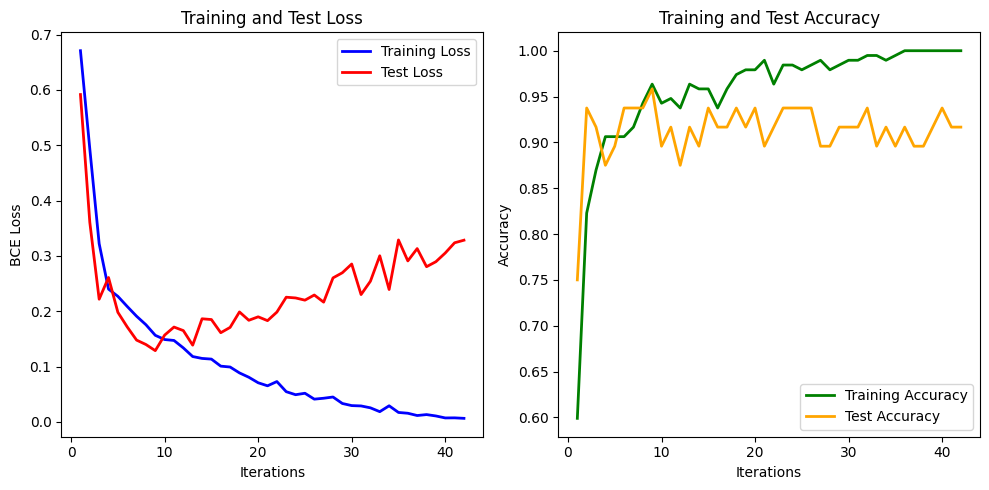

Test Loss = 0.3283684551715851 Test Accuracy = 0.9166666666666666


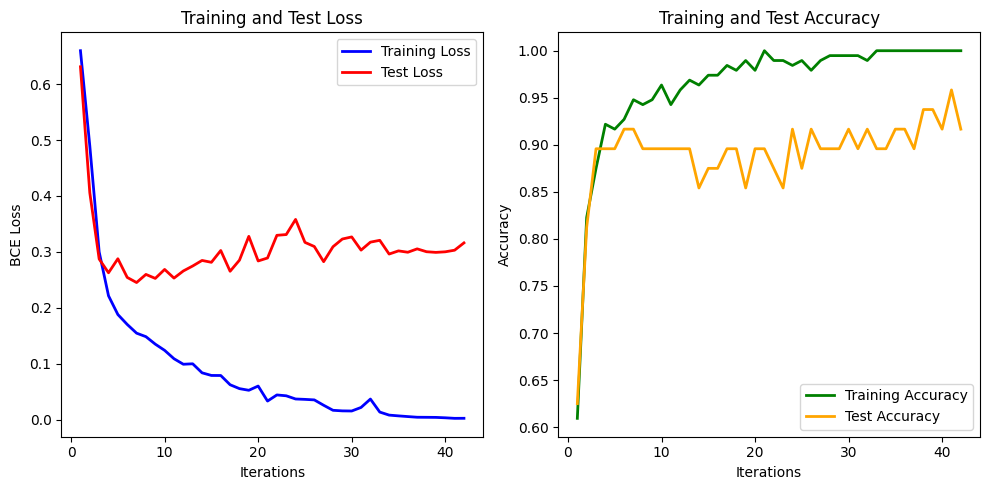

Test Loss = 0.3160741627216339 Test Accuracy = 0.9166666666666666


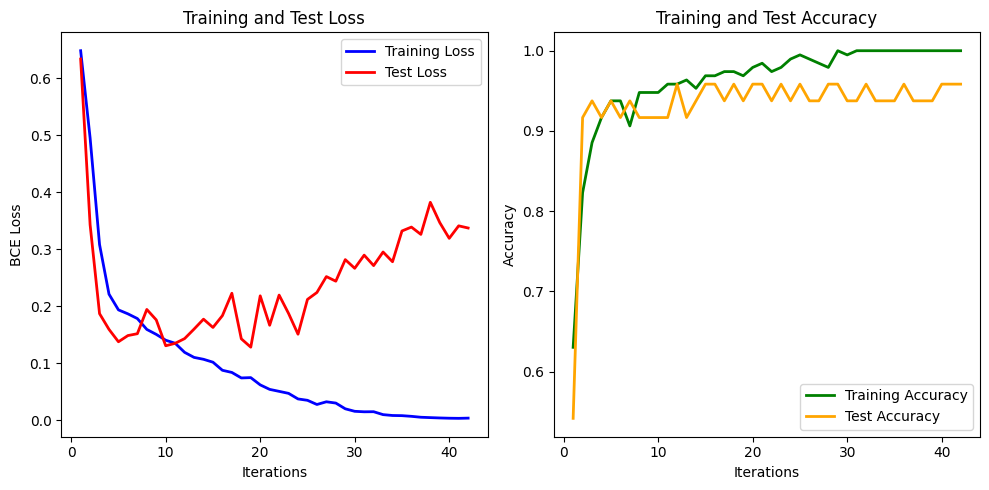

Test Loss = 0.33735302090644836 Test Accuracy = 0.9583333333333334


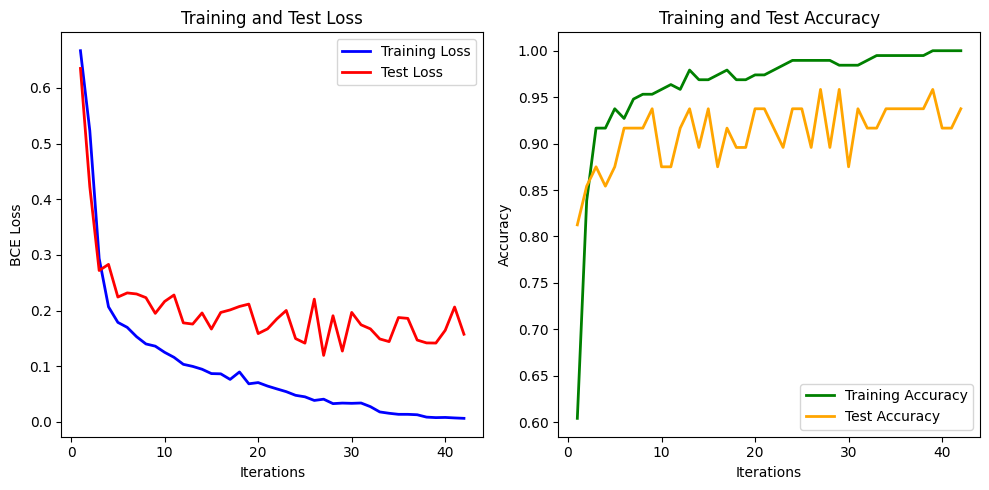

Test Loss = 0.15753783285617828 Test Accuracy = 0.9375


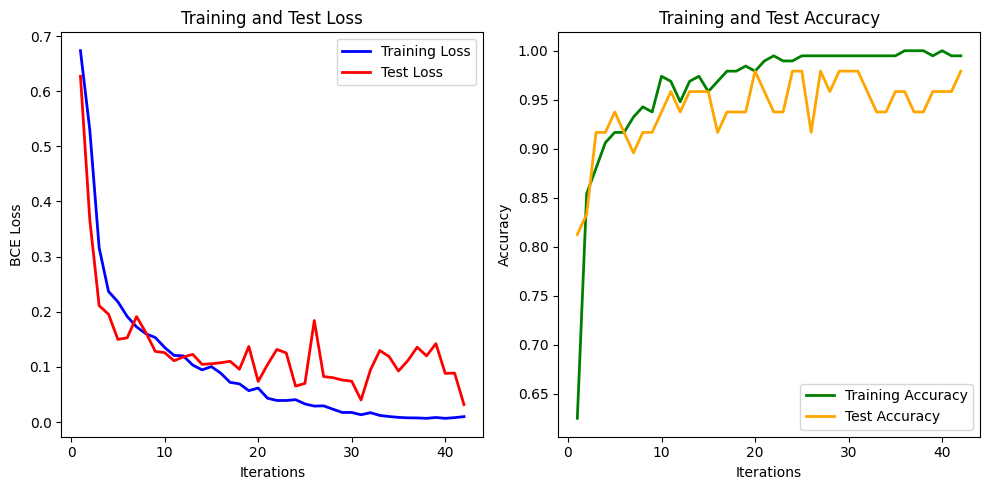

Test Loss = 0.03184375539422035 Test Accuracy = 0.9791666666666666


In [ ]:
i = 0
df = pd.read_excel("final_data492.xlsx", decimal=',')
# Drop unnecessary columns and separate features and target variable
df['n_of_applicants'] = df.groupby(['year', 'is_fall'])['year'].transform('count')
df = df[df['result_1'] == 2]
df.dropna(axis=0, inplace=True)

df_dropped = df.drop(columns=['result_1'])
df_dropped.drop(columns=['year'], inplace=True)

X = df_dropped.drop(columns=['result_2'])
y = df_dropped['result_2'].values

while i < 5:

    # Split the data into train and test sets with random_state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Standardize the data
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    # Convert data into tensors and move to CUDA
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

    criterion = nn.BCELoss()
    criterion = criterion.to(device)
    # Convert data into batches using DataLoader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)

    n_layers = 2
    n_epochs = 42
    dropout = 0.5
    learning_rate = 0.00119874349
    optimizer_name = "Adam"
    batch_size = 1

    model = _get_model(n_layers, dropout)

    optimizer = _get_optimizer(optimizer_name, learning_rate, model)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    earlyStop = False

    for epoch in range(n_epochs):
        if earlyStop:
            break
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to CUDA
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)  # Multiply by batch size to get total loss
            total_train += labels.size(0)
            correct_train += ((outputs >= 0.5) == labels).sum().item()
        epoch_train_loss /= len(train_loader.dataset)  # Divide by total number of samples
        train_losses.append(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        with torch.no_grad():
            model.eval()
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            if epoch > 10 and test_loss.item() > 0.5:
                earlyStop = True
            test_losses.append(test_loss.item())
            test_predictions = (test_outputs >= 0.5).float()
            correct_test = (test_predictions == y_test_tensor).sum().item()
            test_accuracy = correct_test / len(y_test_tensor)
            test_accuracies.append(test_accuracy)
    if earlyStop:
        continue
    i += 1
    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss', color='red', linewidth=2)
    plt.xlabel('Iterations')
    plt.ylabel('BCE Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy', color='green', linewidth=2)
    plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test Accuracy', color='orange', linewidth=2)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # Evaluate the model on test data
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        # Apply threshold
        test_predictions = (test_outputs >= 0.5).float()  # Convert boolean to float (0 or 1)
        # Calculate accuracy
        test_accuracy = (test_predictions == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Loss = {test_loss.item()} Test Accuracy = {test_accuracy}")

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on test data
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predictions = (test_outputs >= 0.5).float()
    correct_test = (test_predictions == y_test_tensor).sum().item()
    test_accuracy = correct_test / len(y_test_tensor)
    test_probs = test_outputs.cpu().numpy().squeeze()  # Convert predictions to numpy array
    test_preds = (test_probs >= 0.5).astype(int)  # Apply threshold for binary classification

    # Generate classification report
    report = classification_report(y_test, test_preds)
    print("Classification Report:")
    print(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        24
         1.0       0.96      1.00      0.98        24

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



In [ ]:
X_test["actual"] = y_test
X_test["pred"] = np.array(test_predictions)
X_test["probabilities"] = np.array(test_outputs)
X_test

,is_fall,is_boun,is_ie,gpa,ales,uni_score,interview_score,n_of_applicants,actual,pred,probabilities
508,1,0,0,3.64,80.000000,438.954275,0.000000,37,0.0,0.0,1.706812e-07
463,1,0,1,3.05,86.550003,291.908540,70.000000,42,0.0,0.0,1.177705e-03
262,0,0,1,3.48,86.150002,483.320000,70.000000,86,1.0,1.0,1.000000e+00
269,0,0,1,3.48,83.000000,383.684536,85.000000,86,1.0,1.0,1.000000e+00
494,1,0,1,3.41,88.480160,445.308230,61.670000,37,1.0,1.0,9.999962e-01
11,1,1,0,2.55,91.452530,510.820800,75.000000,67,1.0,1.0,9.999989e-01
267,0,0,0,2.53,96.589996,446.430000,80.000000,86,1.0,1.0,1.000000e+00
50,1,0,1,3.43,81.918230,434.915020,55.000000,67,0.0,0.0,4.209580e-04
419,0,1,0,2.81,83.389999,491.275550,60.000000,22,0.0,0.0,1.909883e-06
527,0,0,0,2.57,82.083100,518.088430,66.666667,24,0.0,0.0,6.375648e-11


In [ ]:
X_test.to_excel("stage2_NN.xlsx")

In [ ]:
torch.save(model.state_dict(), "NN_stage2.pt")

In [ ]:
mean_values = scaler.mean_
std_dev_values = np.sqrt(scaler.var_)

In [ ]:
mean_values

array([6.87500000e-01, 1.77083333e-01, 4.53125000e-01, 3.07512500e+00,
       8.66493195e+01, 4.34206375e+02, 6.61038368e+01, 6.25364583e+01])

In [ ]:
std_dev_values

array([ 0.46351241,  0.38173921,  0.49779789,  0.3413766 ,  4.69034568,
       68.83339538, 19.16783255, 26.62213842])

In [ ]:
X_test.columns

Index(['is_fall', 'is_boun', 'is_ie', 'gpa', 'ales', 'uni_score',
       'interview_score', 'n_of_applicants', 'actual', 'pred',
       'probabilities'],
      dtype='object')